### Kannada MNIST


El objetivo es clasificar los digitos (0-9) de Kannada. Kannada es un idioma hablado predominantemente por personas de Karnataka en el suroeste de India.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Partición de train-test set
from sklearn.model_selection import train_test_split

#import os
#print(os.listdir("../input"))
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import SubsetRandomSampler, DataLoader
from torch.utils.data import Dataset, DataLoader
import torch.utils
from torchvision import transforms, utils, datasets
import torchsummary
import torchvision.models

In [2]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 31.1 MB/s 


In [3]:
random_state = 432

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Levanto el dataset desde Drive

Se muestra el tamaño del set y las primeras filas.

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/vision_compu_2/Practico4/Kannada-MNIST/train.csv')
#df_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/vision_compu_2/Practico4/Kannada-MNIST/test.csv')

print('Tamaño de train:', df_train.shape)
df_train.head()

Tamaño de train: (60000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Separo en X e y y me fijo el balance de clases.

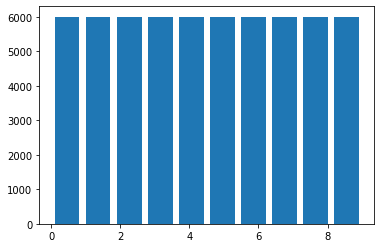

In [7]:
X = df_train.drop('label', axis = 1).values
y = df_train['label'].values

fig, ax = plt.subplots(1)
ax.hist(y, bins = 10, rwidth = 0.8)
plt.show()

#### Split en train y valid (0.8 y 0.2 con estratificado)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = random_state, stratify = y)

print('Entrenamiento:',X_train.shape)
print('Validación:',X_val.shape)
#print('Test:',X_test.shape)

df_train = pd.DataFrame(np.column_stack((y_train, X_train)))
df_val = pd.DataFrame(np.column_stack((y_val, X_val)))
#df_test = pd.DataFrame(np.column_stack((y_test, X_test)))

Entrenamiento: (48000, 784)
Validación: (12000, 784)


#### Creo un custom dataset

In [9]:
class CustomDataset(Dataset):

    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, n):
        data = self.df.iloc[n]
        image = data[1:].values.reshape((28,28)).astype(np.uint8)
        label = data[0]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(padding = 2),
                                      #transforms.Normalize((0.1307,), (0.3081,))
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

In [ ]:
train_set = CustomDataset(df_train, transform = data_transforms)
val_set = CustomDataset(df_val, transform = data_transforms)

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

#### Visualización de alguna imagen

Tamaño del batch de feature (imagen): torch.Size([64, 1, 32, 32])
Tamaño del batch del label (número): torch.Size([64])




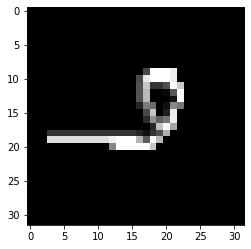


Label: 2


In [ ]:
train_features, train_labels = next(iter(train_loader))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (imagen): {train_features.size()}")
print(f"Tamaño del batch del label (número): {train_labels.size()}")
print("\n")

img = train_features[0]
label = train_labels[0]

plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"\nLabel: {label}")

#### Clase perceptron multicapa

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=1024, out_features=250, bias = True)
    self.tanh_1 = torch.nn.Tanh()
    self.linear_2 = torch.nn.Linear(in_features = 250, out_features = 100, bias = True)
    self.tanh_2 = torch.nn.Tanh()
    self.linear_3 = torch.nn.Linear(in_features = 100, out_features = 10, bias = True)

  def forward(self, x):
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.linear_1(x)
    x = self.tanh_1(x)
    x = self.linear_2(x)
    x = self.tanh_2(x)
    x = self.linear_3(x)
    return x

MLP_model = MLP()

print("La cantidad de parámetros a entrenar es:", 1024*250+250 + 250*100+100 + 100*10+10)

La cantidad de parámetros a entrenar es: 282360


In [ ]:
MLP_optimizer = torch.optim.SGD(MLP_model.parameters(), lr = 0.01)

MLP_loss = torch.nn.CrossEntropyLoss()

MLP_accuracy = torchmetrics.Accuracy()

In [ ]:
# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Seteo los gradientes en cero ya que, por defecto, PyTorch
    # los va acumulando
    MLP_optimizer.zero_grad()

    # Realizo el forward pass de nuestro modelo
    output = MLP_model(train_data)

    # Computo el error de la salida comparando contra las etiquetas
    loss = MLP_loss(output, train_target)

    # Almaceno el error del batch para luego tener el error promedio de la epoca
    epoch_train_loss += loss.item()

    # Computo el nuevo set de gradientes a lo largo de toda la red
    loss.backward()

    # Realizo el paso de optimizacion actualizando los parametros de toda la red
    MLP_optimizer.step()

    # Calculo el accuracy del batch
    accuracy = MLP_accuracy(output, train_target)

    # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  valid_data, valid_target = iter(valid_loader).next()
  output = MLP_model(valid_data)
  epoch_valid_loss = MLP_loss(output, valid_target).item()
  epoch_valid_accuracy = MLP_accuracy(output, valid_target).item()
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 1.022270 - Train Accuracy 0.819458 - Valid Loss 0.328860 - Valid Accuracy 0.937500
Epoch: 2/20 - Train loss 0.279374 - Train Accuracy 0.933958 - Valid Loss 0.208542 - Valid Accuracy 0.953125
Epoch: 3/20 - Train loss 0.201080 - Train Accuracy 0.946292 - Valid Loss 0.194720 - Valid Accuracy 0.953125
Epoch: 4/20 - Train loss 0.171334 - Train Accuracy 0.952562 - Valid Loss 0.075258 - Valid Accuracy 0.984375
Epoch: 5/20 - Train loss 0.153227 - Train Accuracy 0.957521 - Valid Loss 0.268013 - Valid Accuracy 0.921875
Epoch: 6/20 - Train loss 0.142357 - Train Accuracy 0.959771 - Valid Loss 0.098530 - Valid Accuracy 0.968750
Epoch: 7/20 - Train loss 0.133296 - Train Accuracy 0.961625 - Valid Loss 0.061222 - Valid Accuracy 1.000000
Epoch: 8/20 - Train loss 0.126630 - Train Accuracy 0.963375 - Valid Loss 0.083462 - Valid Accuracy 1.000000
Epoch: 9/20 - Train loss 0.120937 - Train Accuracy 0.964958 - Valid Loss 0.150999 - Valid Accuracy 0.953125
Epoch: 10/20 - Train loss 0.

#### Visualización de los resultados

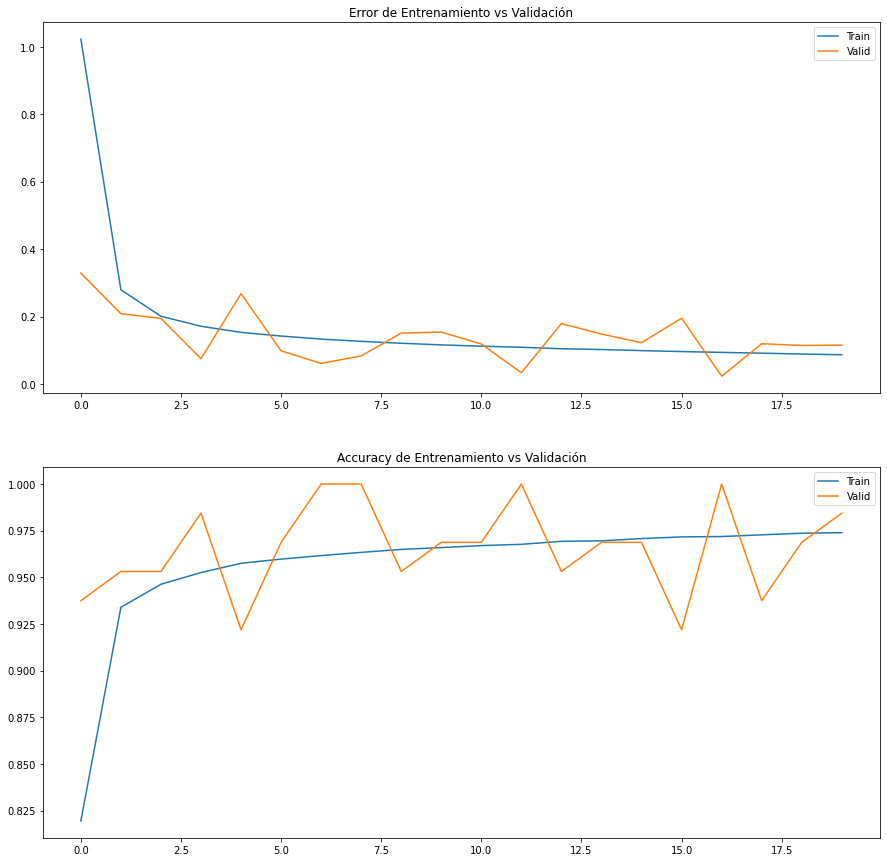

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

#### Implementación de Lenet5

In [22]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding='valid')
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding='valid')
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding='valid')
        self.fc1 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc2 = torch.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

lenet5_model = LeNet5()

print("La cantidad de parámetros a entrenar es:", 1*5*5*6 + 6*5*5*16 + 16*5*5*120 + 120*84 + 84*10)

La cantidad de parámetros a entrenar es: 61470


In [ ]:
#torchsummary.summary(lenet5_model, input_size=(1, 32, 32))

In [24]:
lenet5_optimizer = torch.optim.SGD(lenet5_model.parameters(), lr = 0.01)

lenet5_loss = torch.nn.CrossEntropyLoss()

lenet5_accuracy = torchmetrics.Accuracy()

In [ ]:
# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in train_loader:

    # Seteo los gradientes en cero ya que, por defecto, PyTorch
    # los va acumulando
    lenet5_optimizer.zero_grad()

    # Realizo el forward pass de nuestro modelo
    output = lenet5_model(train_data)

    # Computo el error de la salida comparando contra las etiquetas
    loss = lenet5_loss(output, train_target)

    # Almaceno el error del batch para luego tener el error promedio de la epoca
    epoch_train_loss += loss.item()

    # Computo el nuevo set de gradientes a lo largo de toda la red
    loss.backward()

    # Realizo el paso de optimizacion actualizando los parametros de toda la red
    lenet5_optimizer.step()

    # Calculo el accuracy del batch
    accuracy = lenet5_accuracy(output, train_target)

    # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  valid_data, valid_target = iter(valid_loader).next()
  output = lenet5_model(valid_data)
  epoch_valid_loss = lenet5_loss(output, valid_target).item()
  epoch_valid_accuracy = lenet5_accuracy(output, valid_target).item()
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 2.059053 - Train Accuracy 0.483312 - Valid Loss 1.296548 - Valid Accuracy 0.828125
Epoch: 2/20 - Train loss 0.572492 - Train Accuracy 0.900062 - Valid Loss 0.272480 - Valid Accuracy 0.984375
Epoch: 3/20 - Train loss 0.259718 - Train Accuracy 0.934896 - Valid Loss 0.206100 - Valid Accuracy 0.921875
Epoch: 4/20 - Train loss 0.194462 - Train Accuracy 0.946833 - Valid Loss 0.086059 - Valid Accuracy 0.984375
Epoch: 5/20 - Train loss 0.161772 - Train Accuracy 0.955187 - Valid Loss 0.150522 - Valid Accuracy 0.953125
Epoch: 6/20 - Train loss 0.141459 - Train Accuracy 0.960167 - Valid Loss 0.192733 - Valid Accuracy 0.937500
Epoch: 7/20 - Train loss 0.127140 - Train Accuracy 0.964104 - Valid Loss 0.090952 - Valid Accuracy 0.968750
Epoch: 8/20 - Train loss 0.116444 - Train Accuracy 0.967063 - Valid Loss 0.101022 - Valid Accuracy 0.968750
Epoch: 9/20 - Train loss 0.107662 - Train Accuracy 0.969104 - Valid Loss 0.076650 - Valid Accuracy 0.984375
Epoch: 10/20 - Train loss 0.

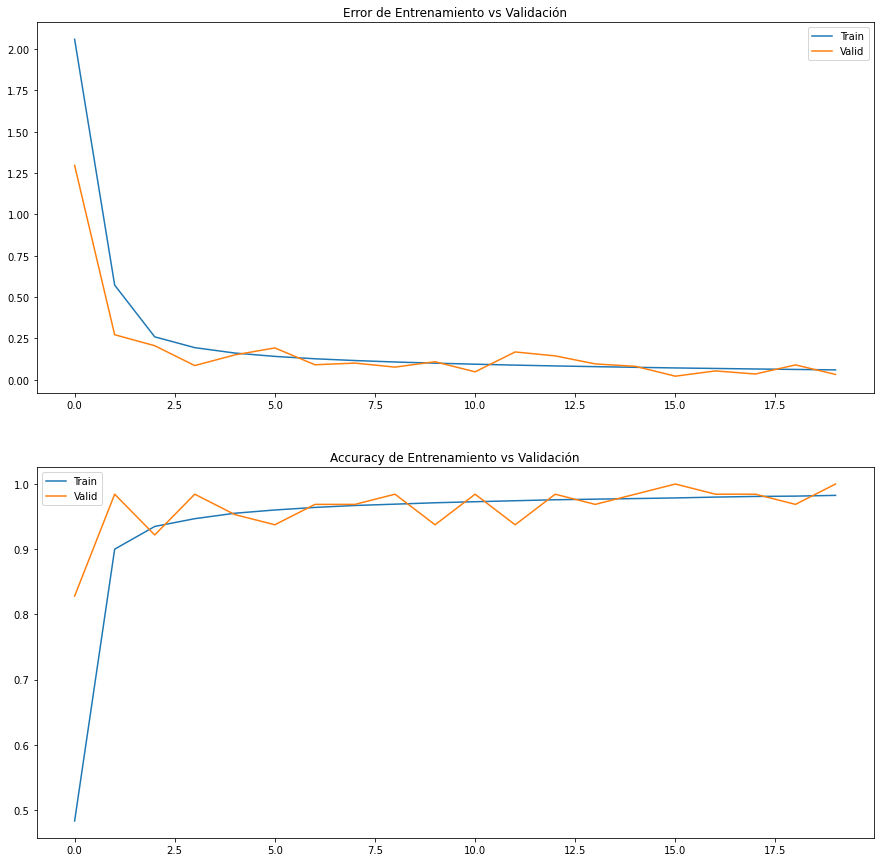

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Tanto el MLP como la red Lenet5 arrojan buenos resultados. La diferencia principal, como se comentó en clase, es el costo computacional. Notar que la Lenet5 tiene 61470 parámetros entrenables mientras que el MLP tiene 282360 (aproximadamente 4.5 veces mas).

#### Data Augmentation

Ahora se entrena el modelo (Lenet5) aplicando la técnica de Data Augmentation.

In [32]:
batch_size = 64

aud_data_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(size=(32, 32)),
                        transforms.RandomHorizontalFlip(0.5),
                        transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0))
                      ])


aug_train_set = CustomDataset(df_train, transform = aud_data_transforms)
aug_val_set = CustomDataset(df_val, transform = aud_data_transforms)


aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size = batch_size, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_val_set, batch_size = batch_size, shuffle=True)

In [33]:
aug_lenet5_model = LeNet5()

In [34]:
aug_lenet5_optimizer = torch.optim.SGD(aug_lenet5_model.parameters(), lr = 0.01)

aug_lenet5_loss = torch.nn.CrossEntropyLoss()

aug_lenet5_accuracy = torchmetrics.Accuracy()

In [35]:
# Epocas de entrenamiento
epochs = 20

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for train_data, train_target in aug_train_loader:

    # Seteo los gradientes en cero ya que, por defecto, PyTorch
    # los va acumulando
    aug_lenet5_optimizer.zero_grad()

    # Realizo el forward pass de nuestro modelo
    output = aug_lenet5_model(train_data)

    # Computo el error de la salida comparando contra las etiquetas
    loss = aug_lenet5_loss(output, train_target)

    # Almaceno el error del batch para luego tener el error promedio de la epoca
    epoch_train_loss += loss.item()

    # Computo el nuevo set de gradientes a lo largo de toda la red
    loss.backward()

    # Realizo el paso de optimizacion actualizando los parametros de toda la red
    aug_lenet5_optimizer.step()

    # Calculo el accuracy del batch
    accuracy = aug_lenet5_accuracy(output, train_target)

    # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(aug_train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(aug_train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  valid_data, valid_target = iter(aug_valid_loader).next()
  output = aug_lenet5_model(valid_data)
  epoch_valid_loss = aug_lenet5_loss(output, valid_target).item()
  epoch_valid_accuracy = aug_lenet5_accuracy(output, valid_target).item()
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 2.249511 - Train Accuracy 0.227917 - Valid Loss 2.014013 - Valid Accuracy 0.453125
Epoch: 2/20 - Train loss 1.677781 - Train Accuracy 0.460875 - Valid Loss 1.191921 - Valid Accuracy 0.671875
Epoch: 3/20 - Train loss 1.297754 - Train Accuracy 0.585917 - Valid Loss 1.186104 - Valid Accuracy 0.640625
Epoch: 4/20 - Train loss 1.031666 - Train Accuracy 0.680979 - Valid Loss 0.926139 - Valid Accuracy 0.703125
Epoch: 5/20 - Train loss 0.854786 - Train Accuracy 0.738771 - Valid Loss 1.006983 - Valid Accuracy 0.718750
Epoch: 6/20 - Train loss 0.725761 - Train Accuracy 0.778167 - Valid Loss 0.688255 - Valid Accuracy 0.734375
Epoch: 7/20 - Train loss 0.637223 - Train Accuracy 0.800104 - Valid Loss 0.470584 - Valid Accuracy 0.859375
Epoch: 8/20 - Train loss 0.573732 - Train Accuracy 0.818667 - Valid Loss 0.458495 - Valid Accuracy 0.828125
Epoch: 9/20 - Train loss 0.530518 - Train Accuracy 0.832833 - Valid Loss 0.418639 - Valid Accuracy 0.890625
Epoch: 10/20 - Train loss 0.

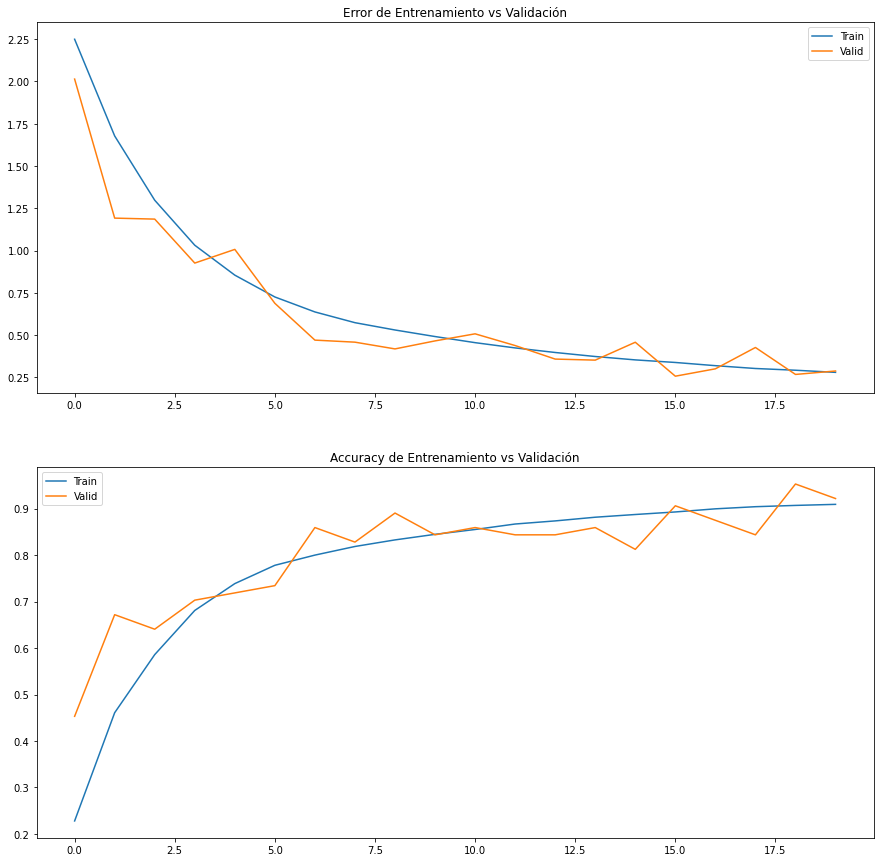

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(train_loss)
axs[0].plot(valid_loss) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Se observa que el modelo es un poco más lento (necesita mas epochs). Esto se debe a que se entrena la red con un conjunto de datos de tamaño considerablemente mayor al dataset original y el modelo observa imágenes nuevas cada paso.

### Autoencoder

#### Definición del autoencoder

In [ ]:
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

In [ ]:
train_set = CustomDataset(df_train, transform = data_transforms)
val_set = CustomDataset(df_val, transform = data_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

In [ ]:
latent_dims = 10
num_epochs = 50
#batch_size = 128
capacity = 64
#learning_rate = 0.01
use_gpu = True

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print('Device:', device)
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Device: cuda:0
Number of parameters: 396171


#### Entrenamiento

In [ ]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.01, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_loader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.264042
Epoch [2 / 50] average reconstruction error: 0.260814
Epoch [3 / 50] average reconstruction error: 0.261827
Epoch [4 / 50] average reconstruction error: 0.260867
Epoch [5 / 50] average reconstruction error: 0.203560
Epoch [6 / 50] average reconstruction error: 0.093040
Epoch [7 / 50] average reconstruction error: 0.086061
Epoch [8 / 50] average reconstruction error: 0.084158
Epoch [9 / 50] average reconstruction error: 0.081561
Epoch [10 / 50] average reconstruction error: 0.082143
Epoch [11 / 50] average reconstruction error: 0.083037
Epoch [12 / 50] average reconstruction error: 0.079445
Epoch [13 / 50] average reconstruction error: 0.079151
Epoch [14 / 50] average reconstruction error: 0.080838
Epoch [15 / 50] average reconstruction error: 0.079421
Epoch [16 / 50] average reconstruction error: 0.078597
Epoch [17 / 50] average reconstruction error: 0.079188
Epoch [18 / 50] average reconstruction error: 0.078671
Epoch 

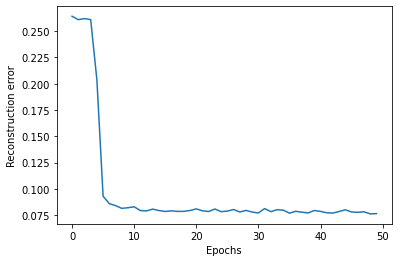

In [ ]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

#### Evaluación en valid set

In [ ]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in valid_loader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.097455


Original images


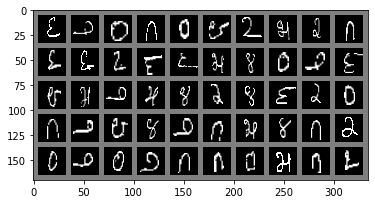

Autoencoder reconstruction:


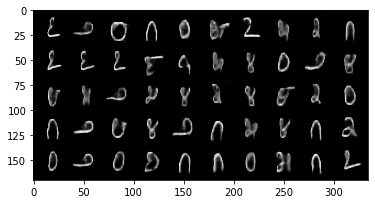

In [ ]:
import torchvision.utils

autoencoder.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(valid_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)


Se observa un buen comportamiento de reconstrucción de imágenes a partir de la reducción de dimensiones.

#### Denoising autoencoder

In [ ]:
denoising_autoencoder = Autoencoder()

autoencoder = denoising_autoencoder.to(device)

In [ ]:
denoising_optimizer = torch.optim.Adam(params=denoising_autoencoder.parameters(), lr = 0.01, weight_decay=1e-5)

# set to training mode
denoising_autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_loader:
        
        noisy_batch = image_batch + torch.Tensor(np.random.uniform(size=image_batch.size()))
        image_batch = image_batch.to(device)
        noisy_batch = noisy_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = denoising_autoencoder(noisy_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        denoising_optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        denoising_optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))


Training ...
Epoch [1 / 50] average reconstruction error: 0.195522
Epoch [2 / 50] average reconstruction error: 0.191572
Epoch [3 / 50] average reconstruction error: 0.128161
Epoch [4 / 50] average reconstruction error: 0.089198
Epoch [5 / 50] average reconstruction error: 0.087164
Epoch [6 / 50] average reconstruction error: 0.085975
Epoch [7 / 50] average reconstruction error: 0.084635
Epoch [8 / 50] average reconstruction error: 0.085094
Epoch [9 / 50] average reconstruction error: 0.084077
Epoch [10 / 50] average reconstruction error: 0.084184
Epoch [11 / 50] average reconstruction error: 0.084223
Epoch [12 / 50] average reconstruction error: 0.083725
Epoch [13 / 50] average reconstruction error: 0.084081
Epoch [14 / 50] average reconstruction error: 0.085155
Epoch [15 / 50] average reconstruction error: 0.084305
Epoch [16 / 50] average reconstruction error: 0.083540
Epoch [17 / 50] average reconstruction error: 0.083501
Epoch [18 / 50] average reconstruction error: 0.083294
Epoch 

Original images


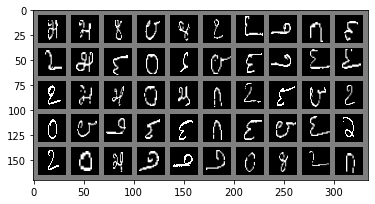

Noisy images


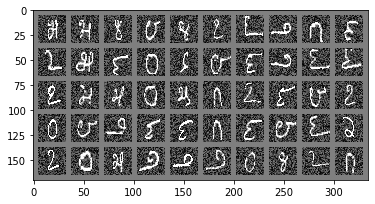

Autoencoder reconstruction:


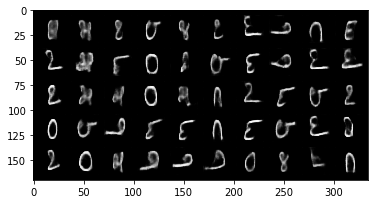

In [ ]:
images, labels = iter(valid_loader).next()

print('Original images')
show_image(torchvision.utils.make_grid(images[:50],10,5))
plt.show()

noise = torch.Tensor(np.random.uniform(size=(64,1,28,28)))
noisy_images = images +  noise

print('Noisy images')
show_image(torchvision.utils.make_grid(noisy_images[:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(noisy_images, denoising_autoencoder)

Muy aceptable la eliminación de ruido en el dataset de imágenes.

### Entrenando una red VGG19 (Transfer learning)

In [10]:
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(padding = 2),
                                      transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                                      ])

In [11]:
train_set = CustomDataset(df_train, transform = data_transforms)
val_set = CustomDataset(df_val, transform = data_transforms)

In [12]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)

#### VGG19 preentrenada

In [14]:
vgg19_model = torchvision.models.vgg19(pretrained=True)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 32, 32))
vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

Congelo las capas

In [15]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [16]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [17]:
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history


In [19]:
result_model, history = train(vgg19_model, criterion, optimizer_ft, train_loader, valid_loader, 10)

Epoch: 1/10 - Train loss 1.162347 - Train Accuracy 0.595896 - Valid Loss 0.738757 - Valid Accuracy 0.798371
Epoch: 2/10 - Train loss 0.814190 - Train Accuracy 0.722667 - Valid Loss 0.623474 - Valid Accuracy 0.826546
Epoch: 3/10 - Train loss 0.744443 - Train Accuracy 0.746479 - Valid Loss 0.589085 - Valid Accuracy 0.825465
Epoch: 4/10 - Train loss 0.714779 - Train Accuracy 0.755958 - Valid Loss 0.562529 - Valid Accuracy 0.836270
Epoch: 5/10 - Train loss 0.700188 - Train Accuracy 0.762021 - Valid Loss 0.539036 - Valid Accuracy 0.849152
Epoch: 6/10 - Train loss 0.685202 - Train Accuracy 0.764229 - Valid Loss 0.531432 - Valid Accuracy 0.850731
Epoch: 7/10 - Train loss 0.681808 - Train Accuracy 0.765146 - Valid Loss 0.520320 - Valid Accuracy 0.853308
Epoch: 8/10 - Train loss 0.671674 - Train Accuracy 0.771104 - Valid Loss 0.522466 - Valid Accuracy 0.847573
Epoch: 9/10 - Train loss 0.664142 - Train Accuracy 0.774896 - Valid Loss 0.510769 - Valid Accuracy 0.857630
Epoch: 10/10 - Train loss 0.

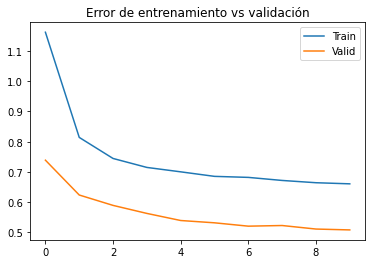

In [20]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

#### Ahora, VGG19 sin preentrenamiemto

In [13]:
vgg19_model = torchvision.models.vgg19()

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 32, 32))
#vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [14]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [15]:
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
result_model, history = train(vgg19_model, criterion, optimizer_ft, train_loader, valid_loader, 10)

Epoch: 1/10 - Train loss 0.356830 - Train Accuracy 0.865729 - Valid Loss 0.056043 - Valid Accuracy 0.985954
Epoch: 2/10 - Train loss 0.050313 - Train Accuracy 0.987812 - Valid Loss 0.041658 - Valid Accuracy 0.990525
Epoch: 3/10 - Train loss 0.038903 - Train Accuracy 0.990375 - Valid Loss 0.028146 - Valid Accuracy 0.993517
Epoch: 4/10 - Train loss 0.033793 - Train Accuracy 0.991979 - Valid Loss 0.044838 - Valid Accuracy 0.989195
Epoch: 5/10 - Train loss 0.029784 - Train Accuracy 0.993437 - Valid Loss 0.025986 - Valid Accuracy 0.994847
Epoch: 6/10 - Train loss 0.026043 - Train Accuracy 0.993833 - Valid Loss 0.069190 - Valid Accuracy 0.985206
Epoch: 7/10 - Train loss 0.024765 - Train Accuracy 0.994271 - Valid Loss 0.026464 - Valid Accuracy 0.994432
Epoch: 8/10 - Train loss 0.017847 - Train Accuracy 0.995979 - Valid Loss 0.030621 - Valid Accuracy 0.994348
Epoch: 9/10 - Train loss 0.020525 - Train Accuracy 0.995792 - Valid Loss 0.035758 - Valid Accuracy 0.992104
Epoch: 10/10 - Train loss 0.

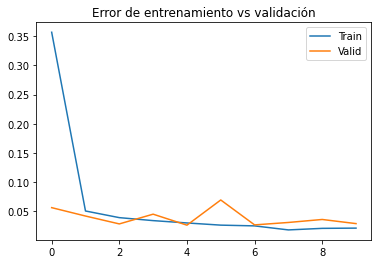

In [19]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

Se observa que el modelo sin preentrenar tiene mejores resultados que el modelo preentrenado (menos epochs). Esto se puede deber al set de datos con el que fue preentrenado.

### Resumen

Para este TP N°4 utilicé el dataset Kannada MNIST. Me propuse como objetivo integrar la mayoría de los conceptos desarrollados durante la cursada.

Como modelo de clasificación base se utilizó la red convolucional Lenet5. En primer instacia se entrenó la red y se compararon sus resultados con los arrojados por una red neuronal densa. Se observa que los resultados son aceptables y similares, sin embargo, el costo computacional para entrenar una red densa es mucho mayor que al de una red convolucional como Lenet5.

Luego se entrena la Lenet5 aplicando Data Augmentation. Se observa que los resultados no mejoran. Esto se debe al tamaño (grande) del set Kannada MNIST. Además, como es de esperar, la velocidad de aprendizaje es menor.

Luego, se entrena un Autoencoder (similar al visto en clases). Resultados aceptables tanto en reconstrucción como en eliminación de ruido.

Por último, se aplica Tranfer Learning a una red VGG19. El entrenamiento se llevó a cabo con la red preentrenada y las capas congeladas, salvo la última capa lineal. Luego se entrenó la VGG19 sin preentrenar ni congelar capas. Sorpresivamente se observa un mejor rendimiento de la VGG19 sin preentrenar. Esto puede deberse a como fue preentrenada la red.